In [ ]:
import tensorflow as tf
print(tf. __version__)

2.12.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [ ]:
train_dir = r"/content/drive/MyDrive/2 classes Meta learning/Implementation Meta learning/Train/"
val_dir = r"/content/drive/MyDrive/2 classes Meta learning/Implementation Meta learning/Validations/"
test_dir = r"/content/drive/MyDrive/2 classes Meta learning/Implementation Meta learning/Test/"

In [ ]:
IMAGE_SIZE = (100,100)
trainDataAll = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                   label_mode = "categorical",
                                                                   image_size = IMAGE_SIZE,
                                                                   shuffle = True )

valDataALL = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                  label_mode = "categorical",
                                                                  image_size = IMAGE_SIZE,
                                                                  shuffle = False)

testDataALL = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  label_mode = "categorical",
                                                                  image_size = IMAGE_SIZE,
                                                                  shuffle = False)

Found 1400 files belonging to 2 classes.
Found 300 files belonging to 2 classes.
Found 300 files belonging to 2 classes.


In [ ]:
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.Rescaling(1. /255)
])

In [ ]:
y_val_labels = []
for images, labels in valDataALL.unbatch(): # unbatch the test data and get images and labels
    y_val_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

In [ ]:
y_test_labels = []
for images, labels in testDataALL.unbatch(): # unbatch the test data and get images and labels
    y_test_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

In [ ]:
class_names = testDataALL.class_names
class_names

['mel', 'nv']

In [ ]:
# Function for Confusion Matrix
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
    """
    Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

     # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

   # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

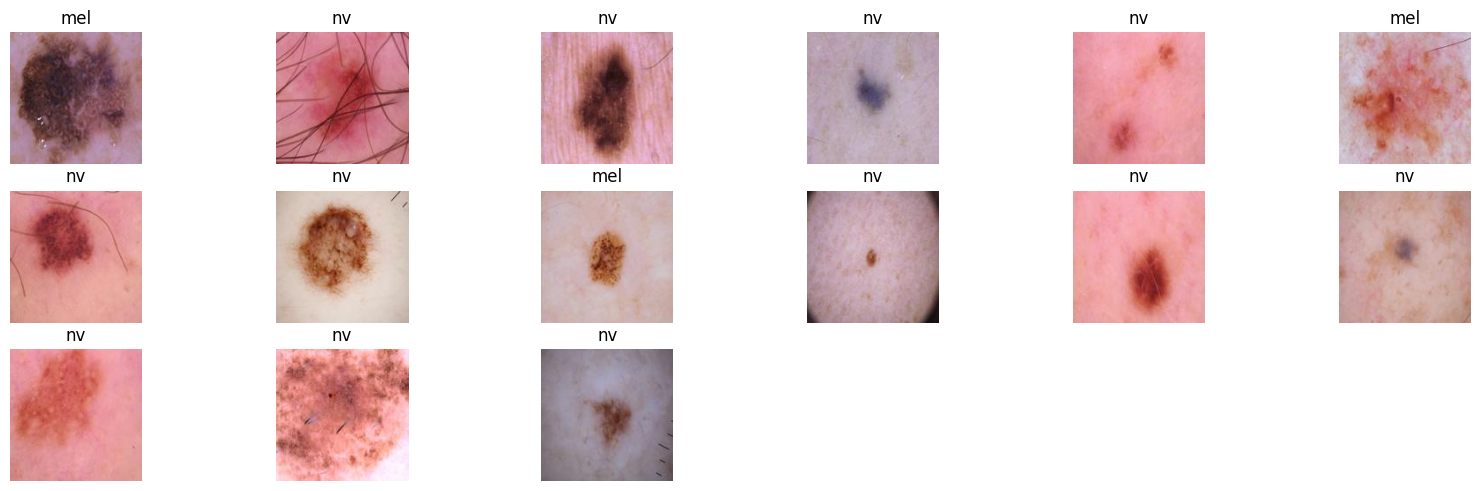

In [ ]:
import os
import random
import matplotlib.image as mpimg

plt.figure(figsize = (20,12))
for i in range(15):
    ax = plt.subplot(6,6,i+1)
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(train_dir + "/" + class_name))
    filepath = train_dir + class_name + "/" + filename
    img = mpimg.imread(filepath)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis(False)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D
from tensorflow.keras.models import Model


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, Conv2D
from tensorflow.keras.models import Model

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Replace pooling layers with adaptive layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Reshape((1, 1, -1))(x)  # Reshape to a 4D tensor with shape (batch_size, 1, 1, num_features)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  # Example of an adaptive Conv2D layer
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)  # Example of another adaptive Conv2D layer

# Add fully connected layers
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# Add the classification layer
num_classes = 2  # Replace with the actual number of classes
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the adaptive fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)

# Set the adaptive learning rates for each layer (if desired)
adaptive_learning_rates = {
    'conv1': 1e-4,
    'conv2_block1_1_conv': 1e-4,
    'conv2_block2_1_conv': 1e-4,
    'conv2_block3_1_conv': 1e-4,
    # Add more layers and learning rates as needed
}



In [ ]:
def adaptive_lr_scheduler(epoch, lr):
    if epoch in adaptive_learning_rates:
        return adaptive_learning_rates[epoch]
    return lr

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint

# Create ModelCheckpoint callback to save the best model weights
checkpoint_callback = ModelCheckpoint(filepath='model.hdf5', monitor='val_accuracy',
                                      save_best_only=True, mode='max')

In [ ]:
history = model.fit(trainDataAll, epochs = 30,
                     batch_size = 32,
                     validation_data = valDataALL,
                     validation_steps = len(valDataALL),
                    callbacks=[checkpoint_callback])

Epoch 1/30
44/44 [==============================] - 187s 3s/step - loss: 0.6952 - accuracy: 0.4621 - val_loss: 0.6936 - val_accuracy: 0.4567
Epoch 2/30
44/44 [==============================] - 7s 145ms/step - loss: 0.6935 - accuracy: 0.4807 - val_loss: 0.6920 - val_accuracy: 0.4833
Epoch 3/30
44/44 [==============================] - 6s 124ms/step - loss: 0.6919 - accuracy: 0.5121 - val_loss: 0.6897 - val_accuracy: 0.5467
Epoch 4/30
44/44 [==============================] - 6s 135ms/step - loss: 0.6904 - accuracy: 0.5307 - val_loss: 0.6882 - val_accuracy: 0.6000
Epoch 5/30
44/44 [==============================] - 6s 125ms/step - loss: 0.6889 - accuracy: 0.5707 - val_loss: 0.6861 - val_accuracy: 0.6267
Epoch 6/30
44/44 [==============================] - 6s 137ms/step - loss: 0.6873 - accuracy: 0.5857 - val_loss: 0.6850 - val_accuracy: 0.6300
Epoch 7/30
44/44 [==============================] - 6s 131ms/step - loss: 0.6850 - accuracy: 0.6193 - val_loss: 0.6831 - val_accuracy: 0.6533
Epoch 8

In [ ]:
y_pred1 = model.predict(testDataALL)

10/10 [==============================] - 1s 49ms/step


In [ ]:
model.evaluate(testDataALL)

10/10 [==============================] - 0s 38ms/step - loss: 0.3616 - accuracy: 0.8700


[0.3616008460521698, 0.8700000047683716]

In [ ]:
sklearn_accuracy = accuracy_score(y_test_labels, np.argmax(y_pred1, axis = 1))

In [ ]:
print('Accuracy of adpative MODEL on Test Data:', sklearn_accuracy)

Accuracy of adpative MODEL on Test Data: 0.87


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
sklearn_accuracy = accuracy_score(y_test_labels, np.argmax(y_pred1, axis = 1))
print('Accuracy of NIN MODEL on Test Data:', sklearn_accuracy)

Accuracy of NIN MODEL on Test Data: 0.87


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, np.argmax(y_pred1, axis = 1), target_names=class_names))

              precision    recall  f1-score   support

         mel       0.84      0.91      0.88       150
          nv       0.91      0.83      0.86       150

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300



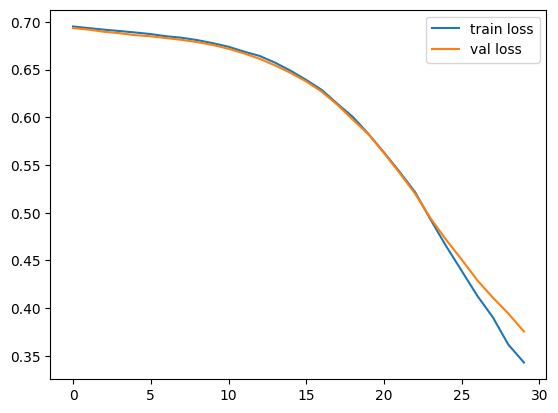

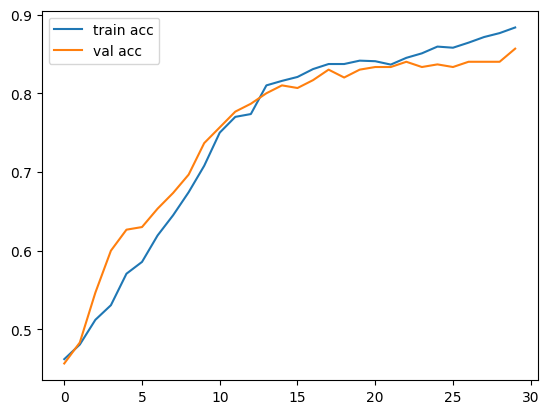

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc' )
plt.plot(history.history['val_accuracy'], label='val acc' )
plt.legend()
plt.show()

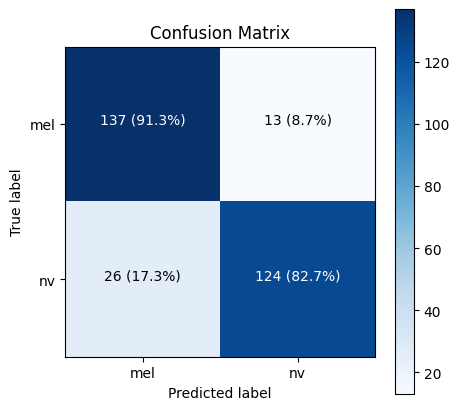

In [ ]:
# Confusion Matrix
make_confusion_matrix(y_true=y_test_labels, # ground truth test labels
                          y_pred=np.argmax(y_pred1, axis = 1), # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(5, 5),
                          text_size=10)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']       

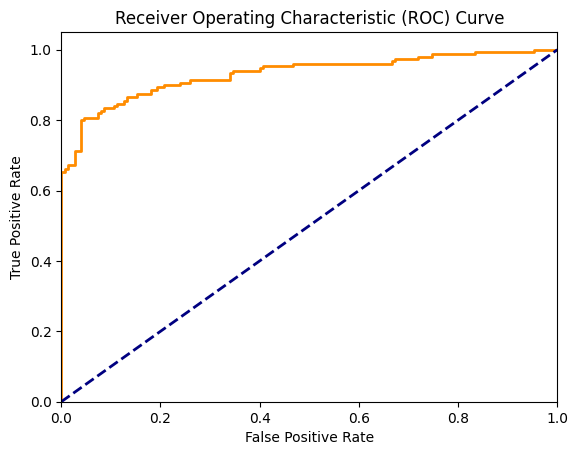

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_test_labels contains the true labels and yhat_test contains the predicted probabilities for the positive class

# Calculate the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(y_test_labels, y_pred1[:, 1])

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

plt.show()